In [1]:
import os
import time
from meidic_vtach_utils.run_on_recommended_cuda import get_cuda_environ_vars as get_vars
os.environ.update(get_vars(select="* -3 -4"))

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.cuda.amp as amp

from IPython.display import display
import nibabel as nib
from torch.utils.checkpoint import checkpoint
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold

from mdl_seg_class.metrics import dice3d
from mdl_seg_class.visualization import get_overlay_grid

import glob
import re
import torch
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm

print(torch.__version__)
print(torch.backends.cudnn.version())
print(torch.cuda.get_device_name(0))


### Recommended gpus on this machine (descending order) ###
  ID  Card name               Util    Mem free  Cuda             User(s)
----  -------------------  -------  ----------  ---------------  -----------
   3  Quadro RTX 8000          0 %   31057 MiB  11.1(455.45.01)  graf
   1  Tesla T4                 0 %   15106 MiB  11.1(455.45.01)  graf
   2  GeForce RTX 2080 Ti      0 %   11016 MiB  11.1(455.45.01)  graf
   4  GeForce RTX 2080 Ti      0 %   11016 MiB  11.1(455.45.01)  graf
   5  GeForce RTX 2080 Ti      0 %   11016 MiB  11.1(455.45.01)  graf
   6  GeForce RTX 2080 Ti      0 %   11016 MiB  11.1(455.45.01)  graf
   0  Tesla T4             ! 100 %    1847 MiB  11.1(455.45.01)  hempe, graf

Will apply following mapping

  ID  Card name        torch
----  -----------  --  -------
   1  Tesla T4     ->  cuda:0
1.9.1+cu102
7605
Tesla T4


In [2]:
class ASPPConv(nn.Sequential):
    def __init__(self, in_channels, out_channels, dilation):
        modules = [
            nn.Conv3d(in_channels, out_channels, 3, padding=dilation, dilation=dilation, bias=False),
            nn.BatchNorm3d(out_channels),
            nn.ReLU()
        ]
        super(ASPPConv, self).__init__(*modules)


class ASPPPooling(nn.Sequential):
    def __init__(self, in_channels, out_channels):
        super(ASPPPooling, self).__init__(
            # nn.AdaptiveAvgPool2d(1),
            nn.Conv3d(in_channels, out_channels, 1, bias=False),
            nn.BatchNorm3d(out_channels),
            nn.ReLU())

    def forward(self, x):
        size = x.shape[-3:]
        # x = F.adaptive_avg_pool3d(x, (1))
        for mod in self:
            x = mod(x)
        return F.interpolate(x, size=size, mode='nearest')  # , align_corners=False)


class ASPP(nn.Module):
    def __init__(self, in_channels, atrous_rates, out_channels=256):
        super(ASPP, self).__init__()
        modules = [nn.Sequential(
            nn.Conv3d(in_channels, out_channels, 1, bias=False),
            nn.BatchNorm3d(out_channels),
            nn.ReLU())]

        rates = tuple(atrous_rates)
        for rate in rates:
            modules.append(ASPPConv(in_channels, out_channels, rate))

        modules.append(ASPPPooling(in_channels, out_channels))

        self.convs = nn.ModuleList(modules)
 
        self.project = nn.Sequential(
            nn.Conv3d(len(self.convs) * out_channels, out_channels, 1, bias=False),
            nn.BatchNorm3d(out_channels),
            nn.ReLU(),
            nn.Dropout(0.5))

    def forward(self, x):
        res = []
        for conv in self.convs:
            res.append(conv(x))
        res = torch.cat(res, dim=1)
        return self.project(res)


# Mobile-Net with depth-separable convolutions and residual connections
class ResBlock(torch.nn.Module):
    def __init__(self, module):
        super().__init__()
        self.module = module

    def forward(self, inputs):
        return self.module(inputs) + inputs


def create_model(output_classes: int = 14,input_channels: int = 1):
    # in_channels = torch.Tensor([1,16,24,24,32,32,32,64]).long()
    in_channels = torch.Tensor([input_channels, 24, 24, 32, 48, 48, 48, 64]).long()
    mid_channels = torch.Tensor([64, 128, 192, 192, 256, 256, 256, 384]).long()
    out_channels = torch.Tensor([24, 24, 32, 48, 48, 48, 64, 64]).long()
    mid_stride = torch.Tensor([1, 1, 1, 2, 1, 1, 1, 1])
    net = [nn.Identity()]
    for i in range(8):
        inc = int(in_channels[i])
        midc = int(mid_channels[i])
        outc = int(out_channels[i])
        strd = int(mid_stride[i])
        layer = nn.Sequential(nn.Conv3d(inc, midc, 1, bias=False), nn.BatchNorm3d(midc), nn.ReLU6(True),
                              nn.Conv3d(midc, midc, 3, stride=strd, padding=1, bias=False, groups=midc),
                              nn.BatchNorm3d(midc), nn.ReLU6(True),
                              nn.Conv3d(midc, outc, 1, bias=False), nn.BatchNorm3d(outc))
        if i == 0:
            layer[0] = nn.Conv3d(inc, midc, 3, padding=1, stride=2, bias=False)
        if (inc == outc) & (strd == 1):
            net.append(ResBlock(layer))
        else:
            net.append(layer)

    backbone = nn.Sequential(*net)

    count = 0
    # weight initialization
    for m in backbone.modules():
        if isinstance(m, nn.Conv3d):
            nn.init.kaiming_normal_(m.weight, mode='fan_out')
            count += 1
            if m.bias is not None:
                nn.init.zeros_(m.bias)
        elif isinstance(m, (nn.BatchNorm3d, nn.GroupNorm)):
            nn.init.ones_(m.weight)
            nn.init.zeros_(m.bias)
        elif isinstance(m, nn.Linear):
            nn.init.normal_(m.weight, 0, 0.01)
            nn.init.zeros_(m.bias)

    print('#CNN layer', count)
    # complete model: MobileNet + ASPP + head (with a single skip connection)
    # newer model (one more stride, no groups in head)
    aspp = ASPP(64, (2, 4, 8, 16, 32), 128)
    head = nn.Sequential(nn.Conv3d(128 + 24, 64, 1, padding=0, groups=1, bias=False), nn.BatchNorm3d(64), nn.ReLU(), \
                         nn.Conv3d(64, 64, 3, groups=1, padding=1, bias=False), nn.BatchNorm3d(64), nn.ReLU(), \
                         nn.Conv3d(64, output_classes, 1))
    return backbone, aspp, head


def apply_model(backbone, aspp, head, img, checkpointing=True, return_intermediate=False):
    if checkpointing:
        x1 = checkpoint(backbone[:3], img)
        x2 = checkpoint(backbone[3:], x1)
        y = checkpoint(aspp, x2)
        y1 = torch.cat((x1[0:1], F.interpolate(y[0:1], scale_factor=2)), 1)
        output_j = checkpoint(head, y1)
    else:
        x1 = backbone[:3](img)
        x2 = backbone[3:](x1)
        y = aspp(x2)
        y1 = torch.cat((x1[0:1], F.interpolate(y[0:1], scale_factor=2)), 1)
        output_j = head(y1)
    if return_intermediate:
        return y1,output_j
    else:
        return output_j


In [3]:
from pathlib import Path

class CrossMoDa_Data(Dataset):
    def __init__(self,
        base_dir, domain, state,
        only_use_labeled_pairs=False, use_additional_data=False, resample = True,
        size:tuple = (96,96,60), normalize:bool = True):
        """
        Function to create Dataset structure with crossMoDa data.
        The function allows to use different preproccessing steps of the crossMoDa data set
        and using additinal data from TCIA database.
        The data can also be resampled to a desired size and normalized to mean=0 and std=1.

        Parameters:
                base_dir (os.Pathlike): provide the directory which contains "L1..." to "L4..." directories
                domain (str): choose which domain to load. Can be set to "source", "target" or "validation". Source are ceT1, target and validation hrT2 images.

                state (str): state of preprocessing:    "l1" = original data,
                                                        "l2" = resampled data @ 0.5mm,
                                                        "l3" = center-cropped data,
                                                        "l4" = image specific crops for desired anatomy

                use_additional_data (bool): set to True to use additional data from TCIA (default: False)

                resample (bool): set to False to disable resampling to desired size (default: True)

                size (tuple): 3d-tuple(int) to which the data is resampled. Unused if resample=False. (default: (96,96,60)).
                    WARNING: choosing large sizes or not resampling can lead to excess memory usage

                normalize (bool): set to False to disable normalization to mean=0, std=1 for each image (default: True)

        Returns:
                torch.utils.data.Dataset containing CrossMoDa data

        Useful Links:
        CrossMoDa challenge:
        https://crossmoda.grand-challenge.org/

        ToDos:
            extend to other preprocessing states

        Example:
            dataset = CrossMoDa_source('original')

            data = dataset.get_data()

        """

        #define finished preprocessing states here with subpath and default size
        states = {
            'l1':('L1_original/', (512,512,160)),
            'l2':('L2_resampled_05mm/', (420,420,360)),
            'l3':('L3_coarse_fixed_crop/', (128,128,192)),
            'l4':('L4_fine_localized_crop/', (128,128,128))
        }
        t0 = time.time()
        #choose directory with data according to chosen preprocessing state
        if state not in states: raise Exception("Unknown state. Choose one of: "+str(states.keys))
        state_dir = states[state.lower()][0] #get sub directory
        if not resample: size = states[state.lower()][1] #set size to default defined at top of file
        path = base_dir + state_dir
        #get file list
        if domain.lower() =="ceT1" or domain.lower() =="source":
            directory = "source_training_labeled/"
            add_directory = "__additional_data_source_domain__"
            domain = "ceT1"
        elif domain.lower() =="hrT2" or domain.lower() =="target":
            directory = "target_training_unlabeled/"
            add_directory = "__additional_data_target_domain__"
            domain = "hrT2"
        elif domain.lower() =="validation":
            directory = "target_validation_unlabeled/"
        else:
            raise Exception("Unknown domain. Choose either 'source', 'target' or 'validation'")
        files = sorted(glob.glob(os.path.join(path+directory , "*.nii.gz")))

        if domain == "hrT2":
            files = files+sorted(glob.glob(os.path.join(path+"__omitted_labels_target_training__" , "*.nii.gz")))
        if domain.lower() =="validation":
            files = files+sorted(glob.glob(os.path.join(path+"__omitted_labels_target_validation__" , "*.nii.gz")))
        if use_additional_data and domain.lower() != "validation": #add additional data to file list
            files = files+sorted(glob.glob(os.path.join(path+add_directory , "*.nii.gz")))
            files = [i for i in files if "additionalLabel" not in i] #remove additional label files

        if only_use_labeled_pairs:
            def get_bare_basename(_path):
                return str(Path(_path.replace('.nii.gz', '')).stem)

            labeled_files = [
                _path for _path in files \
                    if '_Label' in get_bare_basename(_path) \
                    or get_bare_basename(_path)+'_Label' in [get_bare_basename(_path) for _path in files]
            ]
            files = labeled_files
            
        #initialize variables
        self.imgs = torch.zeros(0,size[0],size[1],size[2])
        self.labels = torch.zeros(0,size[0],size[1],size[2])
        self.img_nums = []
        self.label_nums = []
        #load data
        print("Loading CrossMoDa {} images and labels...".format(domain))

        for i,f in enumerate(tqdm(files)):
            # tqdm.write(f"Loading {f}")
            if "Label" in f:
                self.label_nums.append(int(re.findall(r'\d+', os.path.basename(f))[0]))
                tmp = torch.from_numpy(nib.load(f).get_fdata())
                if resample: #resample image to specified size
                    tmp = F.interpolate(tmp.unsqueeze(0).unsqueeze(0), size=size,mode='nearest').squeeze()
                if tmp.shape != size: #for size missmatch use symmetric padding with 0
                    difs = [size[0]-tmp.size(0),size[1]-tmp.size(1),size[2]-tmp.size(2)]
                    pad = (difs[-1]//2,difs[-1]-difs[-1]//2,difs[-2]//2,difs[-2]-difs[-2]//2,difs[-3]//2,difs[-3]-difs[-3]//2)
                    tmp = F.pad(tmp,pad)
                self.labels = torch.cat((self.labels,tmp.unsqueeze(0)),dim=0)
            elif domain in f:
                self.img_nums.append(int(re.findall(r'\d+', os.path.basename(f))[0]))
                tmp = torch.from_numpy(nib.load(f).get_fdata())
                if resample: #resample image to specified size
                    tmp = F.interpolate(tmp.unsqueeze(0).unsqueeze(0), size=size,mode='trilinear',align_corners=False).squeeze()
                if normalize: #normalize image to zero mean and unit std
                    tmp = (tmp - tmp.mean()) / tmp.std()
                if tmp.shape != size: #for size missmatch use symmetric padding with 0
                    difs = [size[0]-tmp.size(0),size[1]-tmp.size(1),size[2]-tmp.size(2)]
                    pad = (difs[-1]//2,difs[-1]-difs[-1]//2,difs[-2]//2,difs[-2]-difs[-2]//2,difs[-3]//2,difs[-3]-difs[-3]//2)
                    tmp = F.pad(tmp,pad)
                self.imgs = torch.cat((self.imgs,tmp.unsqueeze(0)),dim=0)
        self.labels = self.labels.long()
        #check for consistency
        print("Equal image and label numbers: {}".format(self.img_nums==self.label_nums))
        print("Image shape: {}, mean.: {:.2f}, std.: {:.2f}".format(self.imgs.shape,self.imgs.mean(),self.imgs.std()))
        print("Label shape: {}, max.: {}".format(self.labels.shape,torch.max(self.labels)))
        print("Data import finished. Elapsed time: {:.1f} s".format(time.time()-t0 ))

    def __len__(self):
        return int(self.imgs.size(0))

    def __getitem__(self, idx):
        image = self.imgs[idx]
        label = self.labels[idx]
        return image, label.long()

    def get_data(self):
        return self.imgs,self.labels

    def get_image_numbers(self):
        return self.img_nums

    def get_label_numbers(self):
        return self.label_nums

In [4]:
#training routine
def display_nonempty_seg_slices(img_slices, seg_slices, alpha=.5):
    color_map = {
        0: None, 
        1: (255,0,0), #ONEHOT id and RGB color
        2: (0,255,0)
    }

    idx_dept_with_segs, *_ = torch.nonzero(seg_slices > 0, as_tuple=True)
    idx_dept_with_segs = idx_dept_with_segs.unique()

    img_slices = img_slices[idx_dept_with_segs]
    seg_slices = seg_slices[idx_dept_with_segs]
    
    pil_ov, _ = get_overlay_grid(
        img_slices, 
        torch.nn.functional.one_hot(seg_slices,3), 
        color_map, n_per_row=10, alpha=alpha
    )
    display(pil_ov)

In [5]:
# training_dataset = CrossMoDa_Data("/share/data_supergrover1/weihsbach/shared_data/tmp/CrossMoDa/", 
#     domain="source", state="l4", only_use_labeled_pairs=True)
validation_dataset = CrossMoDa_Data("/share/data_supergrover1/weihsbach/shared_data/tmp/CrossMoDa/", 
    domain="validation", state="l4", only_use_labeled_pairs=True)
# target_dataset = CrossMoDa_Data("/share/data_supergrover1/weihsbach/shared_data/tmp/CrossMoDa/", 
#     domain="target", state="l4", only_use_labeled_pairs=True)

Loading CrossMoDa validation images and labels...


100%|██████████| 38/38 [00:02<00:00, 12.83it/s]


Equal image and label numbers: True
Image shape: torch.Size([19, 96, 96, 60]), mean.: -0.00, std.: 1.00
Label shape: torch.Size([19, 96, 96, 60]), max.: 2
Data import finished. Elapsed time: 3.1 s


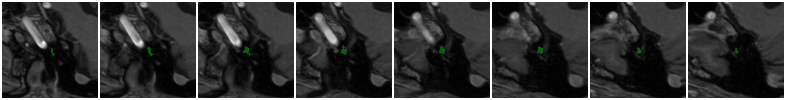

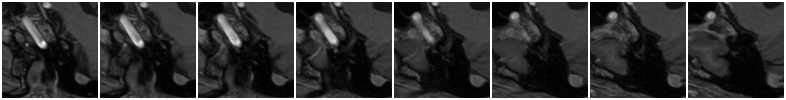

In [9]:
img, seg = training_dataset[104]
img_slices = img.permute(2,0,1).unsqueeze(1)
seg_slices = seg.permute(2,0,1)
display_nonempty_seg_slices(img_slices, seg_slices, alpha=.3)
display_nonempty_seg_slices(img_slices, seg_slices, alpha=.0)

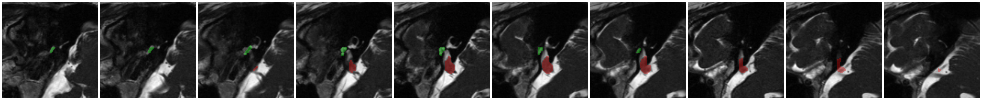

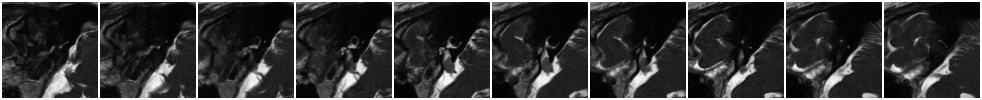

In [10]:
img, seg = validation_dataset[9]
img_slices = img.permute(2,0,1).unsqueeze(1)
seg_slices = seg.permute(2,0,1)
display_nonempty_seg_slices(img_slices, seg_slices, alpha=.3)
display_nonempty_seg_slices(img_slices, seg_slices, alpha=.0)

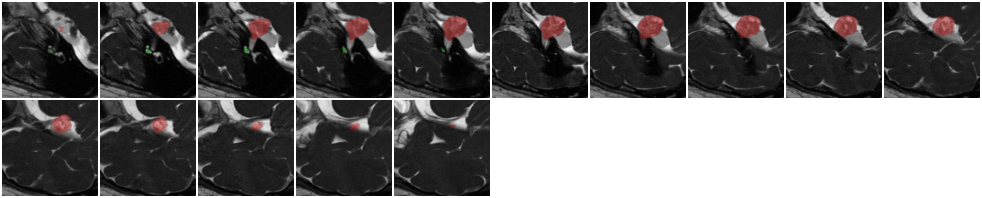

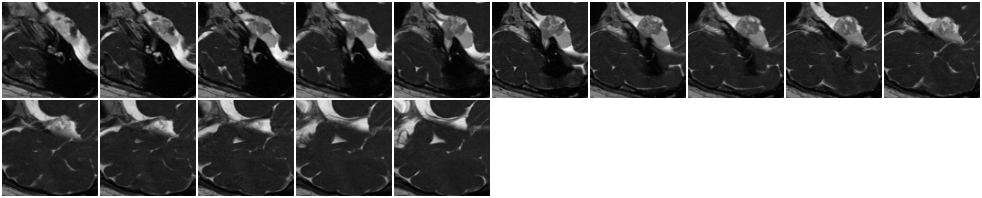

In [11]:
img, seg = target_dataset[30]
img_slices = img.permute(2,0,1).unsqueeze(1)
seg_slices = seg.permute(2,0,1)
display_nonempty_seg_slices(img_slices, seg_slices, alpha=.3)
display_nonempty_seg_slices(img_slices, seg_slices, alpha=.0)

In [6]:
def augmentAffine(img_in, seg_in, strength=0.05):
    """
    3D affine augmentation on image and segmentation mini-batch on GPU.
    (affine transf. is centered: trilinear interpolation and zero-padding used for sampling)
    :input: img_in batch (torch.cuda.FloatTensor), seg_in batch (torch.cuda.LongTensor)
    :return: augmented BxCxTxHxW image batch (torch.cuda.FloatTensor), augmented BxTxHxW seg batch (torch.cuda.LongTensor)
    """
    B,C,D,H,W = img_in.size()
    affine_matrix = (torch.eye(3,4).unsqueeze(0) + torch.randn(B, 3, 4) * strength).to(img_in.device)

    meshgrid = F.affine_grid(affine_matrix,torch.Size((B,1,D,H,W)))

    img_out = F.grid_sample(img_in, meshgrid,padding_mode='border')
    seg_out = F.grid_sample(seg_in.float(), meshgrid, mode='nearest')

    return img_out, seg_out



def augmentNoise(img_in,strength=0.05):
    return img_in + strength*torch.randn_like(img_in)


    
def pad_center_plane(img,size):
    s0,s1,s2 = img.size()
    i0 = (size[0]-s0)//2
    i1 = (size[1]-s1)//2
    i2 = 0
    pd = (i2,size[2]-s2-i2,i1,size[1]-s1-i1,i0,size[0]-s0-i0)
    #print('pad',pd)
    img = F.pad(img, pd, "constant", 0)
    return img



def crop_center_plane(img, size):
    s0,s1,s2 = img.size()
    i0 = (s0-size[0])//2
    i1 = (s1-size[1])//2
    i2 = 0
    img = img[i0:i0+size[0],i1:i1+size[1],i2:i2+size[2]]
    return img

In [7]:
def train_DL(training_dataset, validation_dataset,
    epochs=500, update_epx = 50, use_mind = True, debug=False):

    if use_mind:
        C =12
    else:
        C = 1
    all_segs = torch.cat([seg for _, seg in training_dataset])

    num_class = int(torch.max(all_segs).item()+1)
    class_weight = torch.sqrt(1.0/(torch.bincount(all_segs.long().view(-1)).float()))
    class_weight = class_weight/class_weight.mean()
    class_weight[0] = 0.15
    class_weight = class_weight.cuda()
    print('inv sqrt class_weight', class_weight)

    kf = KFold(n_splits=2)
    kf.get_n_splits(training_dataset)
    train_idx, val_idx = next(kf.split(training_dataset))
    train_subsampler = torch.utils.data.SubsetRandomSampler(train_idx)
    val_subsampler = torch.utils.data.SubsetRandomSampler(val_idx)

    train_dataloader = DataLoader(training_dataset, batch_size=1, shuffle=False, sampler=train_subsampler)
    val_dataloader = DataLoader(training_dataset, batch_size=1, shuffle=False, sampler=val_subsampler)

    backbone, aspp, head = create_model(output_classes=num_class,input_channels=C)
    optimizer = torch.optim.Adam(list(backbone.parameters())+list(aspp.parameters())+list(head.parameters()),lr=0.001)

    criterion = nn.CrossEntropyLoss(class_weight)
    scaler = amp.GradScaler()
    backbone.cuda() 
    backbone.train()
    aspp.cuda() 
    aspp.train()
    head.cuda() 
    head.train()
    t0 = time.time()

    for epx in range(epochs):
        optimizer.zero_grad()
        b_img, b_seg = next(iter(train_dataloader))
        b_img, b_seg = b_img.unsqueeze(0).float().cuda(), b_seg.unsqueeze(0).float().cuda()
        
        if use_mind:
            # img = mindssc(img)
            pass

        b_img, b_seg = augmentAffine(b_img, b_seg, strength=0.1)
        b_img = augmentNoise(b_img, strength=0.02)
        
        if debug:
            img_slices = b_img[0:1].permute(0,1,4,2,3).squeeze().unsqueeze(1)
            seg_slices = b_seg[0:1].permute(0,1,4,2,3).squeeze().to(dtype=torch.int64)
            display_nonempty_seg_slices(img_slices, seg_slices)
            
        b_interpolated_seg = F.interpolate(b_seg, scale_factor=0.5, mode='nearest').squeeze(0).long()

        b_img.requires_grad = True
        #img_mr.requires_grad = True
        with amp.autocast(enabled=True):
            output_j = apply_model(backbone,aspp,head,b_img,checkpointing=True)
            loss = criterion(output_j, b_interpolated_seg)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        if epx%update_epx==update_epx-1 or epx == 0:
            dice = dice3d(
                torch.nn.functional.one_hot(output_j.argmax(1), 3),
                torch.nn.functional.one_hot(b_interpolated_seg, 3), one_hot_torch_style=True
            )

            with amp.autocast(enabled=True):
                with torch.no_grad():
                    b_val_img, b_val_seg = next(iter(val_dataloader))
                    b_val_img, b_val_seg = (
                        b_val_img.unsqueeze(0).float().cuda(), 
                        b_val_seg.unsqueeze(0).float().cuda()
                    )
                    b_interpolated_val_seg = F.interpolate(b_seg, scale_factor=0.5, mode='nearest').squeeze(0).long()
                    output_val = apply_model(backbone,aspp,head,b_val_img,checkpointing=True)
                
                    val_dice = dice3d(
                        torch.nn.functional.one_hot(output_val.argmax(1), 3),
                        torch.nn.functional.one_hot(b_interpolated_val_seg, 3), one_hot_torch_style=True
                    )

            print(
                'epx',epx,round(time.time()-t0,2),'s',
                'loss',round(loss.item(),6),
                'dice_tensor',dice, 
                'dice mean (nobg)', round(dice.mean(dim=0)[1:].mean().item(),4),
                'val_dice_mean (nobg)', round(val_dice.mean(dim=0)[1:].mean().item(),4)
            )
        
        if debug:
            break
#    stat_cuda('Visceral training')
    backbone.cpu()
    aspp.cpu() 
    head.cpu()

    return backbone,aspp,head

In [9]:
def save_model(backbone,aspp,head,name):
    torch.save(backbone.state_dict(), name + '_backbone.pth')
    torch.save(aspp.state_dict(), name + '_aspp.pth')
    torch.save(head.state_dict(), name + '_head.pth')
    return None

def load_model(name,output_classes,input_channels):
    backbone, aspp, head = create_model(output_classes=output_classes,input_channels=input_channels)
    backbone.load_state_dict(torch.load( name + '_backbone.pth'))
    aspp.load_state_dict(torch.load(name + '_aspp.pth'))
    head.load_state_dict(torch.load(name + '_head.pth'))
    return backbone,aspp,head

In [16]:

epochs = 2000
updates = 50
# imgs = torch.cat((imgs_train_source,imgs_train_target),dim=0)
# label = torch.cat((labels_train_source,labels_train_target),dim=0)
backbone,aspp,head = train_DL(training_dataset, validation_dataset, 
    epochs=epochs, update_epx=updates, use_mind=False, debug=False
)

save_model(backbone, aspp, head,'data/models')

inv sqrt class_weight tensor([0.1500, 0.6111, 2.3484], device='cuda:0')
#CNN layer 24


/share/data_supergrover1/weihsbach/shared_data/tmp/curriculum_deeplab/.venv/lib/python3.9/site-packages/torch/nn/functional.py:4043: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(
/share/data_supergrover1/weihsbach/shared_data/tmp/curriculum_deeplab/.venv/lib/python3.9/site-packages/torch/nn/functional.py:3981: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(
/share/data_supergrover1/weihsbach/shared_data/tmp/curriculum_deeplab/.venv/lib/python3.9/site-packages/torch/nn/functional.py:3657: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other fra

epx 0 0.37 s loss 1.145309 dice_tensor tensor([[0.5208, 0.0552, 0.0008]]) dice mean (nobg) 0.028 val_dice_mean (nobg) 0.0208
epx 49 10.52 s loss 0.131634 dice_tensor tensor([[0.9992, 0.0000, 0.1148]]) dice mean (nobg) 0.0574 val_dice_mean (nobg) 0.0847
epx 99 20.91 s loss 0.073774 dice_tensor tensor([[0.9953, 0.7546, 0.3261]]) dice mean (nobg) 0.5403 val_dice_mean (nobg) 0.1111
epx 149 31.34 s loss 0.048865 dice_tensor tensor([[0.9967, 0.8775, 0.2467]]) dice mean (nobg) 0.5621 val_dice_mean (nobg) 0.0898
epx 199 41.81 s loss 0.03197 dice_tensor tensor([[0.9976, 0.8614, 0.2366]]) dice mean (nobg) 0.549 val_dice_mean (nobg) 0.2328
epx 249 52.31 s loss 0.017461 dice_tensor tensor([[0.9989, 0.0000, 0.2727]]) dice mean (nobg) 0.1364 val_dice_mean (nobg) 0.1136
epx 299 62.84 s loss 0.012414 dice_tensor tensor([[0.9993, 0.0000, 0.2836]]) dice mean (nobg) 0.1418 val_dice_mean (nobg) 0.0
epx 349 73.39 s loss 0.012132 dice_tensor tensor([[0.9993, 0.0000, 0.2524]]) dice mean (nobg) 0.1262 val_dic

In [10]:
backbone, aspp, head = load_model('data/models', output_classes=3, input_channels=1)

#CNN layer 24


In [13]:
def inference_DL(
    backbone, aspp, head, 
    inf_dataset, use_mind = True, display_nonempty=True):

    backbone.cuda() 
    backbone.eval()
    aspp.cuda() 
    aspp.eval()
    head.cuda() 
    head.eval()
    all_dices = []

    for sample_idx, (img, seg) in enumerate(inf_dataset):

        img, seg = (
            img.unsqueeze(0).unsqueeze(0).float().cuda(), 
            seg.unsqueeze(0).unsqueeze(0).float().cuda()
        )
        
        if use_mind:
            # img = mindssc(img)
            pass

        if display_nonempty:
            img_slices = img[0:1].permute(0,1,4,2,3).squeeze().unsqueeze(1)
            seg_slices = seg[0:1].permute(0,1,4,2,3).squeeze().to(dtype=torch.int64)
            display_nonempty_seg_slices(img_slices, seg_slices)
            
        interpolated_seg = F.interpolate(seg, scale_factor=0.5, mode='nearest').squeeze(0).long()

        img.requires_grad = True
        with amp.autocast(enabled=True):
            with torch.no_grad():
               
                interpolated_seg = F.interpolate(seg, scale_factor=0.5, mode='nearest').squeeze(0).long()
                output_val = apply_model(backbone,aspp,head,img,checkpointing=True)

                inf_dice = dice3d(
                    torch.nn.functional.one_hot(output_val.argmax(1), 3),
                    torch.nn.functional.one_hot(interpolated_seg, 3), one_hot_torch_style=True
                )
            if display_nonempty_seg_slices:
                lbl_slices = interpolated_seg.detach().unsqueeze(1)[0:1].permute(0,1,4,2,3)
                pred_seg_slices = output_val.detach()[0:1].permute(0,1,4,2,3).squeeze().to(dtype=torch.int64)
                display_nonempty_seg_slices(lbl_slices, pred_seg_slices)

            mean_no_bg = inf_dice.mean(dim=0)[1:].mean()
            all_dices.append(mean_no_bg)
            print(
                'sample', sample_idx,
                'dice_tensor',inf_dice, 
                'dice mean (nobg)', round(mean_no_bg.item(),4),
            )
    
    print(f"Mean dice over all classes and samples: {torch.stack(all_dices).mean().item()*100:.2f}%")


In [15]:
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
inference_DL(backbone, aspp, head, validation_dataset, use_mind = False, display_nonempty=True)

RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call,so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.

In [ ]:
path = '/share/data_sam1/ckruse/image_data/CrossMoDa/target_training/'
label_path = '/share/data_supergrover1/weihsbach/tmp/crossmoda_full_set/'
plot = False
backbone.cuda() 
aspp.cuda() 
head.cuda() 
target_dices = torch.zeros(32)
source_dices = torch.zeros(32)
for i in range(32):
    ind = i+150
    nii_img = nib.load(path + 'crossmoda_'+ str(ind) + '_hrT2.nii.gz')
    nii_label = nib.load(label_path + 'crossmoda_'+ str(ind) + '_hrT2_Label.nii.gz')
    tmp = torch.from_numpy(nii_img.get_fdata())
    label = torch.from_numpy(nii_label.get_fdata()).cuda()
    org_size = tmp.size()  
    size = (192,192,64)
    tmp = crop_center_plane(tmp,size)
    tmp = (tmp - tmp.mean()) / tmp.std()
    org_img = torch.from_numpy(nii_img.get_fdata())
    
    img= tmp.float().cuda()
    img = mindssc(img.unsqueeze(0).unsqueeze(0))
    with torch.no_grad():
        with amp.autocast(enabled=True):
            output_j = apply_model(backbone,aspp,head,img,checkpointing=False)#
    modeled_seg = F.interpolate(output_j,scale_factor=2).argmax(1)
    modeled_seg = pad_center_plane(modeled_seg.squeeze(),org_size)
    #print(modeled_seg.shape,torch.max(modeled_seg))
    connectivity = 18 # only 4,8 (2D) and 26, 18, and 6 (3D) are allowed
    np_label = modeled_seg.long().cpu().numpy().astype('int32')
    tmp = pad_center_plane(tmp.squeeze(),org_size)
    #plot = True
    if plot:
        slc = 30
        i0 = overlaySegment(tmp[:,:,slc].cpu(), modeled_seg[:,:,slc].cpu(), flag=False)
        i1 = overlaySegment(org_img[:,:,slc].cpu(), modeled_seg[:,:,slc].cpu(), flag=False)
        fig,axs = plt.subplots(1, 2,figsize=(18, 9))
        axs[0].imshow((i0+i1).cpu().numpy())
        axs[1].imshow(i1.cpu().numpy())
        plt.show()
        fig.set_figwidth(40)
        fig.set_figheight(10)
    #print(modeled_seg.shape,torch.max(modeled_seg))
    target_dices[i] = dice_coeff(modeled_seg,label)
    print(f'image: crossmoda_{ind}_hrT2.nii.gz, dice: {target_dices[i]*100:0.2f}')
    
print(f'target dice mean: {target_dices.mean()*100:0.2f}')


In [ ]:
path = '/share/data_sam1/ckruse/image_data/CrossMoDa/target_validation/'
plot = False
save = True
backbone.cuda() 
aspp.cuda() 
head.cuda() 
for i in range(32):
    ind = i+211
    nii_img = nib.load(path + 'crossmoda_'+ str(ind) + '_hrT2.nii.gz')
    img_affine = nii_img.affine
    tmp = torch.from_numpy(nii_img.get_fdata())
    org_img = torch.from_numpy(nii_img.get_fdata())
    org_size = tmp.size()  
    size = (192,192,64)
    tmp = crop_center_plane(tmp,size)
    #print('red. shape',tmp.shape)
    #tmp = F.interpolate(tmp.unsqueeze(0).unsqueeze(0), size=size)
    tmp = (tmp - tmp.mean()) / tmp.std()
        
    img= tmp.float().cuda()
    #print(img.shape)
    img = mindssc(img.unsqueeze(0).unsqueeze(0))
    with torch.no_grad():
        with amp.autocast(enabled=True):
            output_j = apply_model(backbone,aspp,head,img,checkpointing=False)#
    modeled_seg = F.interpolate(output_j,scale_factor=2).argmax(1)
    modeled_seg = pad_center_plane(modeled_seg.squeeze(),org_size)
    tmp = pad_center_plane(tmp.squeeze(),org_size)
    #print('org shape',tmp.shape)
    if plot:
        slc = 30
        i0 = overlaySegment(tmp[:,:,slc].cpu(), modeled_seg[:,:,slc].cpu(), flag=False)
        i1 = overlaySegment(org_img[:,:,slc].cpu(), modeled_seg[:,:,slc].cpu(), flag=False)
        fig,axs = plt.subplots(1, 2,figsize=(18, 9))
        axs[0].imshow((i0+i1).cpu().numpy())
        axs[1].imshow(i1.cpu().numpy())
        plt.show()
        fig.set_figwidth(40)
        fig.set_figheight(10)
    if save:
        label_nii = nib.Nifti1Image(modeled_seg.float().squeeze().cpu().numpy(), img_affine)
        nib.save(label_nii, 'Deeplab_validation/crossmoda_'+ str(ind) + '_Label.nii.gz')  
        

In [ ]:
#!rm Deeplab_validation.zip
#!zip -r Deeplab_validation_half_res_adapted_model_target_train.zip Deeplab_validation